In [1]:
import tensorflow as tf
from keras import layers, models
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np



In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [3]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)



In [4]:
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)                
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    encoded = layers.Conv2D(16, (3, 3), activation='relu',
                            padding='same', name="bottleneck")(x)

    # Decoder
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)


In [5]:
autoencoder = build_autoencoder()
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['mse']           
)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=8,
                           restore_best_weights=True)

In [6]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100,                
    batch_size=256,            
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

Epoch 1/100
235/235 [==============================] - 13s 37ms/step - loss: 0.3466 - mse: 0.0310 - val_loss: 0.8828 - val_mse: 0.1772
Epoch 2/100
235/235 [==============================] - 8s 35ms/step - loss: 0.3023 - mse: 0.0188 - val_loss: 0.3810 - val_mse: 0.0492
Epoch 3/100
235/235 [==============================] - 8s 35ms/step - loss: 0.2983 - mse: 0.0176 - val_loss: 0.3055 - val_mse: 0.0192
Epoch 4/100
235/235 [==============================] - 8s 35ms/step - loss: 0.2963 - mse: 0.0170 - val_loss: 0.2991 - val_mse: 0.0171
Epoch 5/100
235/235 [==============================] - 8s 36ms/step - loss: 0.2946 - mse: 0.0164 - val_loss: 0.2990 - val_mse: 0.0174
Epoch 6/100
235/235 [==============================] - 8s 35ms/step - loss: 0.2938 - mse: 0.0162 - val_loss: 0.2954 - val_mse: 0.0160
Epoch 7/100
235/235 [==============================] - 8s 36ms/step - loss: 0.2927 - mse: 0.0158 - val_loss: 0.2952 - val_mse: 0.0160
Epoch 8/100
235/235 [==============================] - 8s 36m

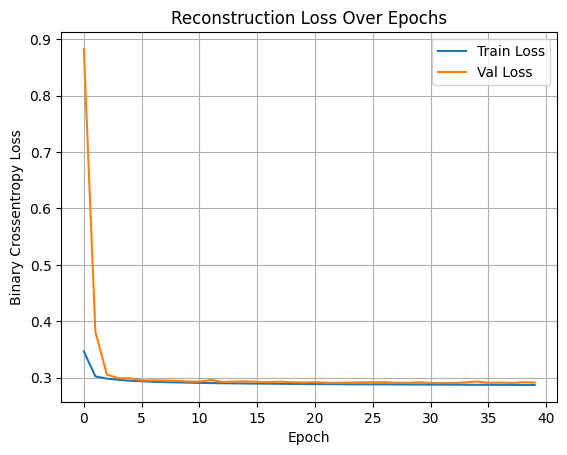

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 156ms/step


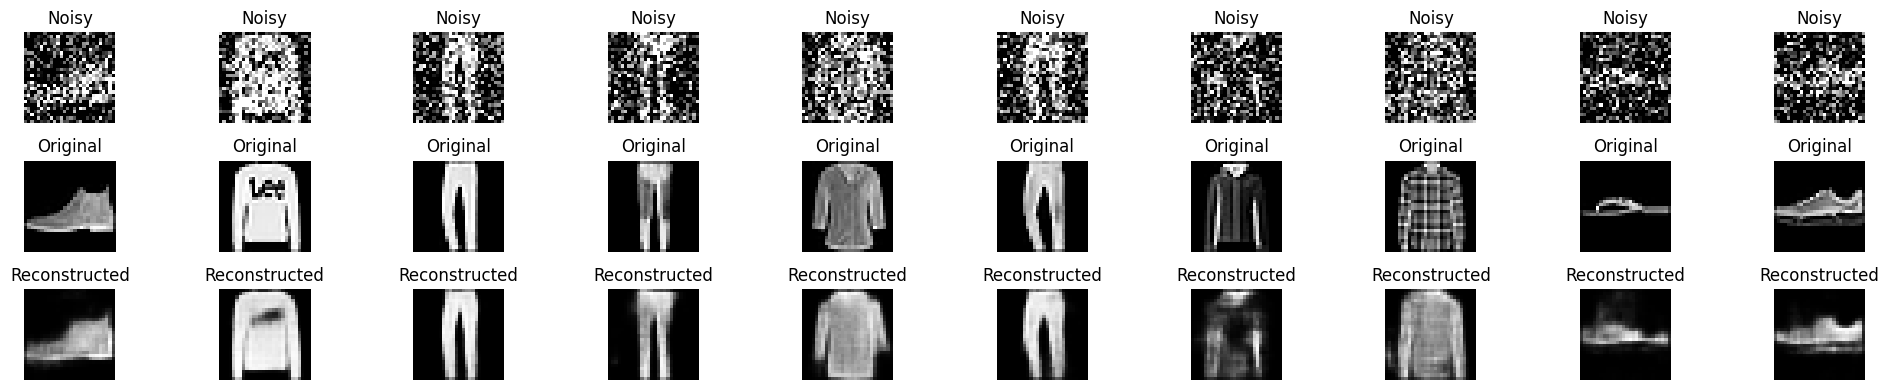

In [8]:
decoded_imgs = autoencoder.predict(x_test_noisy[:10])

plt.figure(figsize=(20, 4))
for i in range(10):
    # Noisy input
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()

